In [1]:
import os
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (FuncFormatter)

from pprint import pprint as pp
from tqdm import tqdm

## Define Constants

In [2]:
RAW_DATA_PATH = '../data/raw'
PROCESSED_DATA_PATH = '../data/processed'
ERROR_DATA_PATH = '../data/errors'

for path in [RAW_DATA_PATH, PROCESSED_DATA_PATH, ERROR_DATA_PATH]:
    if not os.path.exists(path):
        os.makedirs(path)

In [3]:
CONFIRMED_CASES_FILE = 'CONVENIENT_us_confirmed_cases.csv'
CONFIRMED_DEATHS_FILE = 'CONVENIENT_us_deaths.csv'
CONFIRMED_CASES_RAW_FILE = 'RAW_us_confirmed_cases.csv'
MASK_USE_FILE = 'mask-use-by-county.csv'
MASK_MANDATE_FILE = 'U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv'

In [4]:
COUNTY_NAME = 'Philadelphia'
STATE_NAME = 'Pennsylvania'
STATE_NAME_ABB = 'PA'
COUNTY_NAME_MASK_MANDATE_STR = f'{COUNTY_NAME} County'

COUNTY_FIPS_CODE = 42101

COUNTY_POPULATION = 1603797

In [5]:
COMBINED_DATA_FILE = f'{COUNTY_NAME}-{STATE_NAME}-Covid-Data.csv'

## Process confirmed cases/deaths data

In [6]:
confirmed_cases_df = pd.read_csv(
    os.path.join(RAW_DATA_PATH, CONFIRMED_CASES_FILE), 
    low_memory=False,
    header=[0,1]
)

In [7]:
confirmed_deaths_df = pd.read_csv(
    os.path.join(RAW_DATA_PATH, CONFIRMED_DEATHS_FILE), 
    low_memory=False,
    header=[0,1]
)

In [8]:
confirmed_cases_df.head()

Province_State Alabama                                                     \
          Admin2 Autauga Baldwin Barbour Bibb Blount Bullock Butler Calhoun   
0        1/23/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   
1        1/24/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   
2        1/25/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   
3        1/26/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   
4        1/27/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   

            ... Wyoming                                                  \
  Chambers  ...    Park Platte Sheridan Sublette Sweetwater Teton Uinta   
0      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   
1      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   
2      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   
3      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   
4      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   

                              
  Unassigned Washakie Weston  
0        0.0      0.0    0.0  
1        0.0      0.0    0.0  
2        0.0      0.0    0.0  
3        0.0      0.0    0.0  
4        0.0      0.0    0.0  

[5 rows x 3343 columns]

In [9]:
confirmed_deaths_df.head()

Province_State Alabama                                                     \
          Admin2 Autauga Baldwin Barbour Bibb Blount Bullock Butler Calhoun   
0        1/23/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   
1        1/24/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   
2        1/25/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   
3        1/26/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   
4        1/27/20     0.0     0.0     0.0  0.0    0.0     0.0    0.0     0.0   

            ... Wyoming                                                  \
  Chambers  ...    Park Platte Sheridan Sublette Sweetwater Teton Uinta   
0      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   
1      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   
2      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   
3      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   
4      0.0  ...     0.0    0.0      0.0      0.0        0.0   0.0   0.0   

                              
  Unassigned Washakie Weston  
0        0.0      0.0    0.0  
1        0.0      0.0    0.0  
2        0.0      0.0    0.0  
3        0.0      0.0    0.0  
4        0.0      0.0    0.0  

[5 rows x 3343 columns]

In [10]:
# Extract the data for my assigned state and county
philly_cases_df = pd.DataFrame((confirmed_cases_df['Province_State']['Admin2']).copy())
philly_cases_df['Cases'] = (confirmed_cases_df[STATE_NAME][COUNTY_NAME]).copy()

philly_cases_df.rename(
    columns={"Admin2": "Date"},
    inplace=True
)

# Parse the date col as the correct type
philly_cases_df['Date'] = pd.to_datetime(philly_cases_df['Date'])

# Keep data only for the daterange we want:  February 1, 2020 through October 15, 2021
mask = (philly_cases_df['Date'] >= '2020-2-1') & (philly_cases_df['Date'] <= '2021-10-15')
philly_cases_df = philly_cases_df.loc[mask]

# Compute a moving average to remove the spikes in cases
philly_cases_df['Cases Moving Average'] = philly_cases_df.Cases.rolling(window=7).mean().round()
philly_cases_df['Cases Cumulative'] = philly_cases_df['Cases'].cumsum()

philly_cases_df.head()

,Date,Cases,Cases Moving Average,Cases Cumulative
9,2020-02-01,0.0,NaN,0.0
10,2020-02-02,0.0,NaN,0.0
11,2020-02-03,0.0,NaN,0.0
12,2020-02-04,0.0,NaN,0.0
13,2020-02-05,0.0,NaN,0.0


In [11]:
# Extract the data for my assigned state and county
philly_deaths_df = pd.DataFrame((confirmed_deaths_df['Province_State']['Admin2']).copy())
philly_deaths_df['Deaths'] = (confirmed_deaths_df[STATE_NAME][COUNTY_NAME]).copy()

philly_deaths_df.rename(
    columns={"Admin2": "Date"},
    inplace=True
)

# Parse the date col as the correct type
philly_deaths_df['Date']= pd.to_datetime(philly_deaths_df['Date'])

# Keep data only for the daterange we want:  February 1, 2020 through October 15, 2021
mask = (philly_deaths_df['Date'] >= '2020-2-1') & (philly_deaths_df['Date'] <= '2021-10-15')
philly_deaths_df = philly_deaths_df.loc[mask]

# Compute a moving average to remove the spikes in deaths
philly_deaths_df['Deaths Moving Average'] = philly_deaths_df.Deaths.rolling(window=7).mean().round()
philly_deaths_df['Deaths Cumulative'] = philly_deaths_df['Deaths'].cumsum()

philly_deaths_df.head()

,Date,Deaths,Deaths Moving Average,Deaths Cumulative
9,2020-02-01,0.0,NaN,0.0
10,2020-02-02,0.0,NaN,0.0
11,2020-02-03,0.0,NaN,0.0
12,2020-02-04,0.0,NaN,0.0
13,2020-02-05,0.0,NaN,0.0


### Merge the data frames for processing

In [12]:
philly_cases_df = pd.merge(philly_cases_df, philly_deaths_df, 
                           how='left', on='Date'
)

philly_cases_df['Initial Population'] = COUNTY_POPULATION
philly_cases_df['Susceptible Population'] = philly_cases_df['Initial Population'] - philly_cases_df['Deaths Cumulative'] - philly_cases_df['Cases Cumulative']

philly_cases_df['Rate of Infection'] = (philly_cases_df['Cases Moving Average'] / philly_cases_df['Susceptible Population']) * 100
philly_cases_df['Rate of Daily Infection'] = (philly_cases_df['Cases'] / philly_cases_df['Susceptible Population']) * 100

philly_cases_df['Rate of Cases'] = ((philly_cases_df['Cases Moving Average'].diff()) / COUNTY_POPULATION) * 100
philly_cases_df['Rate of Daily Cases'] = ((philly_cases_df['Cases'].diff()) / COUNTY_POPULATION) * 100

In [13]:
philly_cases_df.tail(30)

,Date,Cases,Cases Moving Average,Cases Cumulative,Deaths,Deaths Moving Average,Deaths Cumulative,Initial Population,Susceptible Population,Rate of Infection,Rate of Daily Infection,Rate of Cases,Rate of Daily Cases
593,2021-09-16,348.0,301.0,170332.0,6.0,4.0,3871.0,1603797,1429594.0,0.021055,0.024343,0.002182,-0.004427
594,2021-09-17,371.0,308.0,170703.0,2.0,3.0,3873.0,1603797,1429221.0,0.021550,0.025958,0.000436,0.001434
595,2021-09-18,0.0,308.0,170703.0,0.0,3.0,3873.0,1603797,1429221.0,0.021550,0.000000,0.000000,-0.023133
596,2021-09-19,0.0,308.0,170703.0,0.0,3.0,3873.0,1603797,1429221.0,0.021550,0.000000,0.000000,0.000000
597,2021-09-20,653.0,282.0,171356.0,4.0,4.0,3877.0,1603797,1428564.0,0.019740,0.045710,-0.001621,0.040716
598,2021-09-21,373.0,309.0,171729.0,5.0,3.0,3882.0,1603797,1428186.0,0.021636,0.026117,0.001684,-0.017459
599,2021-09-22,403.0,307.0,172132.0,4.0,3.0,3886.0,1603797,1427779.0,0.021502,0.028226,-0.000125,0.001871
600,2021-09-23,373.0,310.0,172505.0,3.0,3.0,3889.0,1603797,1427403.0,0.021718,0.026131,0.000187,-0.001871
601,2021-09-24,387.0,313.0,172892.0,3.0,3.0,3892.0,1603797,1427013.0,0.021934,0.027120,0.000187,0.000873
602,2021-09-25,0.0,313.0,172892.0,0.0,3.0,3892.0,1603797,1427013.0,0.021934,0.000000,0.000000,-0.024130


### Visualize - Trends in daily cases ?

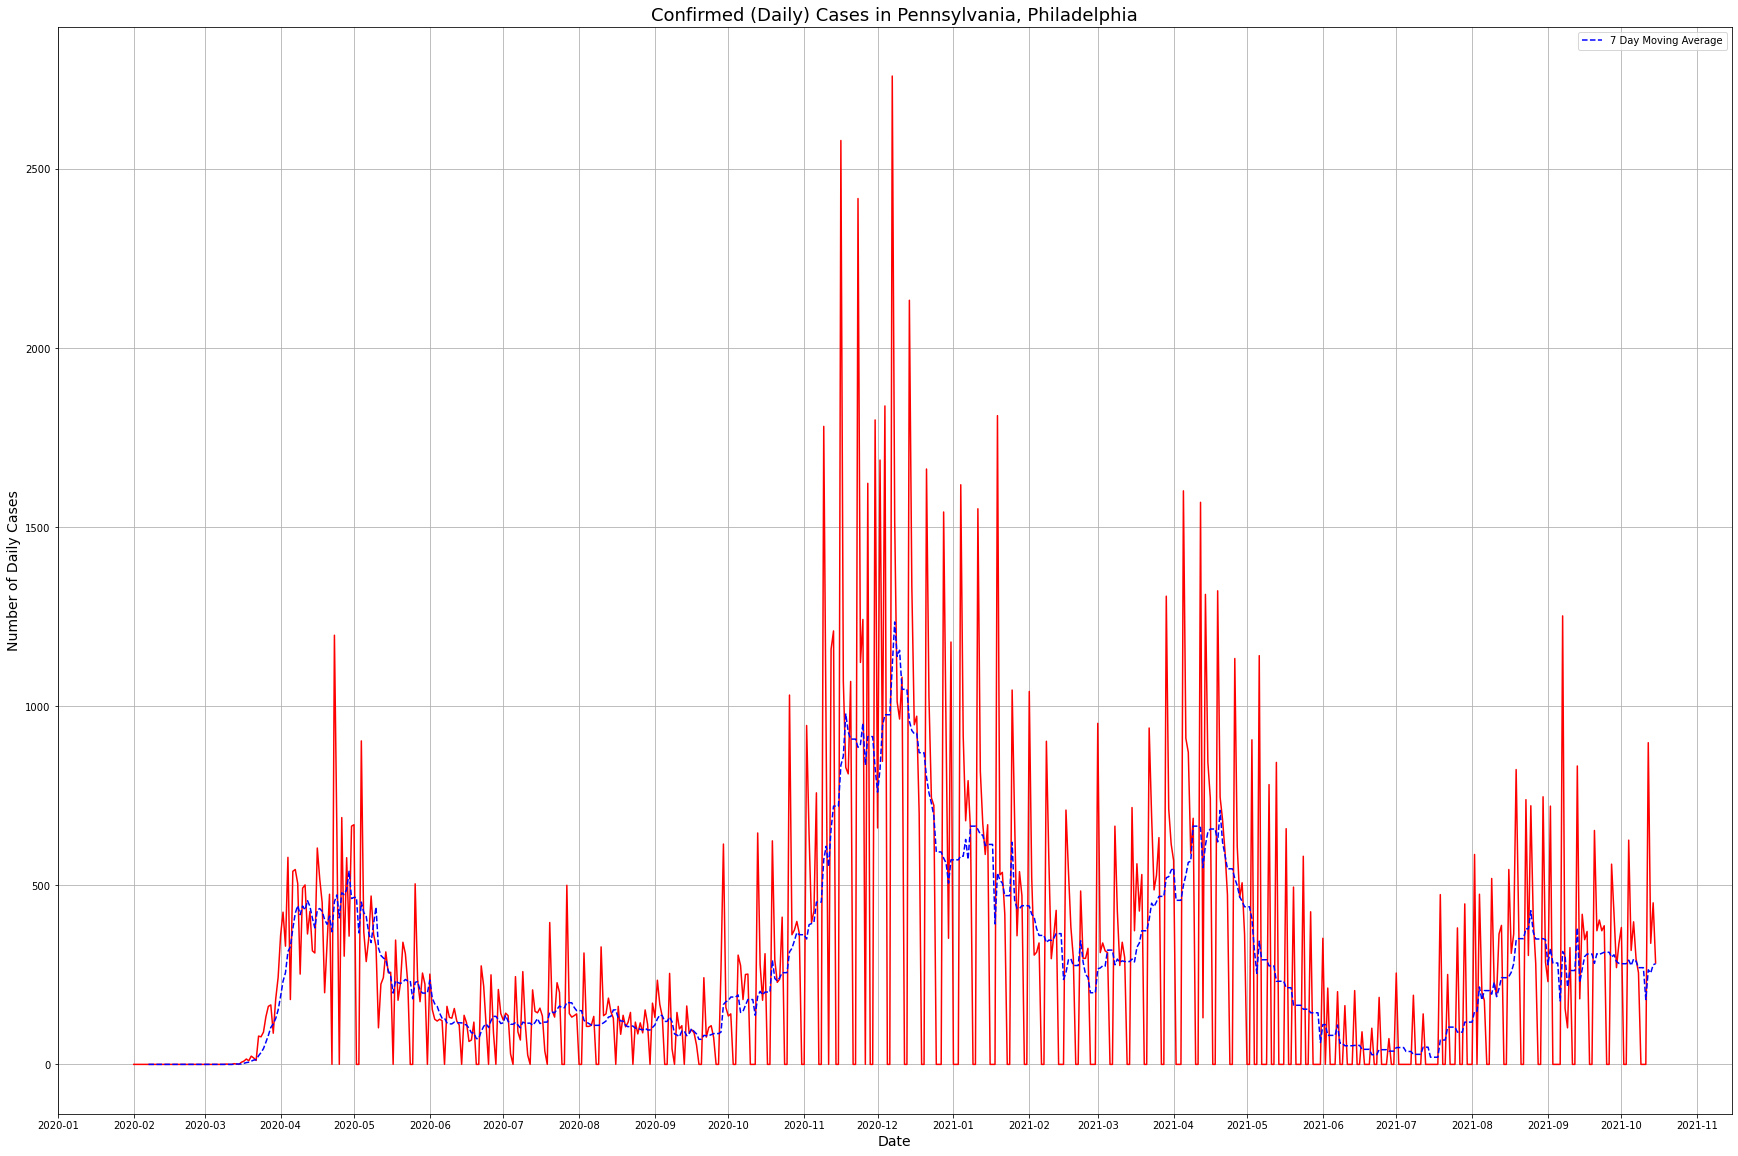

In [14]:
plt.figure(figsize=(30,20))
ax = plt.gca()
# ax2 = ax.twinx()

# Create lines and choose characteristics
ax.plot('Date', 'Cases', 'r', data=philly_cases_df, label='')
ax.plot('Date', 'Cases Moving Average', 'b--', data=philly_cases_df, label='7 Day Moving Average')

# format the x-ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_minor_locator(months)

# Add title and axis names
plt.title(f'Confirmed (Daily) Cases in {STATE_NAME}, {COUNTY_NAME}', fontsize=18)
plt.xlabel('Date', fontsize=14)
ax.set_ylabel('Number of Daily Cases', fontsize=14)
# ax2.set_ylabel('Number of Deaths', fontsize=14)

plt.grid()
ax.legend()

### Visualize - Trends in daily cases/deaths

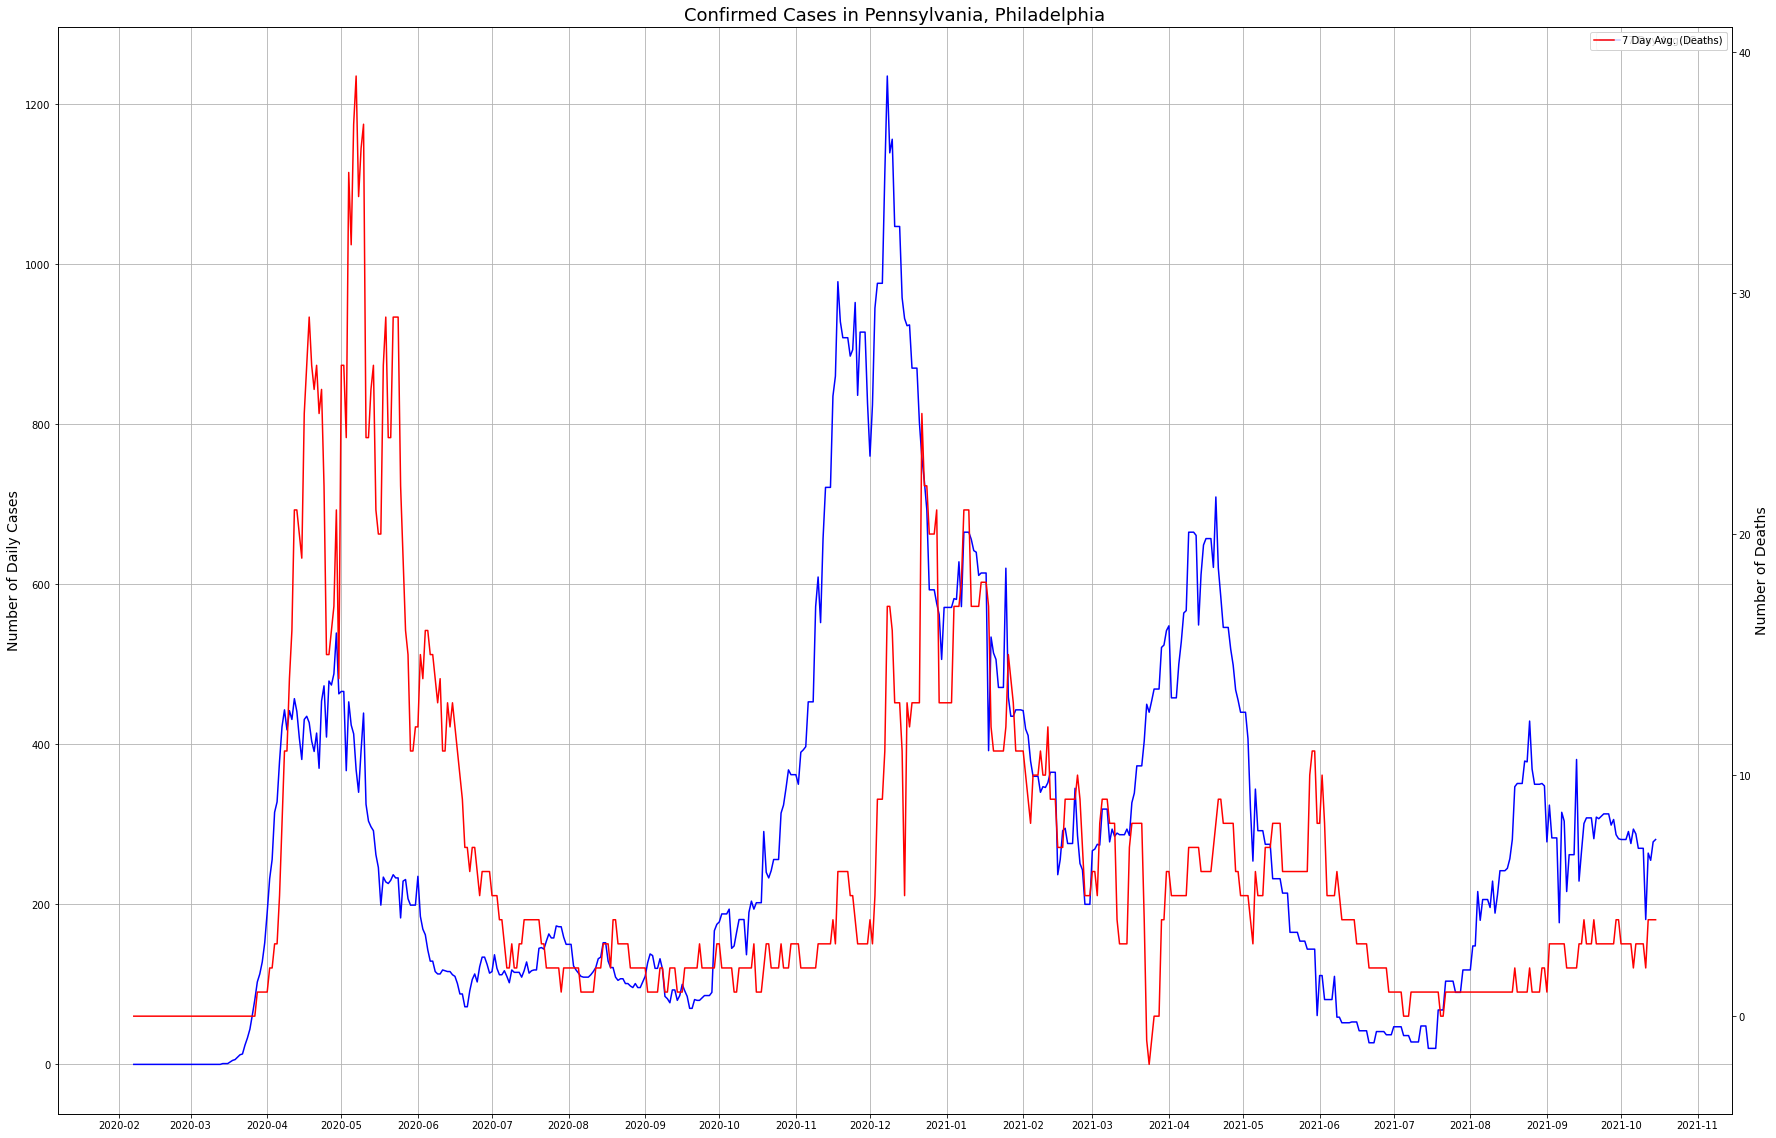

In [15]:
plt.figure(figsize=(30,20))
ax = plt.gca()
ax2 = ax.twinx()

# Create lines and choose characteristics
ax.plot('Date', 'Cases Moving Average', 'b', data=philly_cases_df, label='7 Day Avg. (Cases)')
ax2.plot('Date', 'Deaths Moving Average', 'r', data=philly_cases_df, label='7 Day Avg. (Deaths)')

# format the x-ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_minor_locator(months)

# Add title and axis names
plt.title(f'Confirmed Cases in {STATE_NAME}, {COUNTY_NAME}', fontsize=18)
plt.xlabel('Date', fontsize=14)
ax.set_ylabel('Number of Daily Cases', fontsize=14)
ax2.set_ylabel('Number of Deaths', fontsize=14)

ax.grid()
ax.legend()
ax2.legend()

### Visualize - Trends in cumulative cases/deaths ?

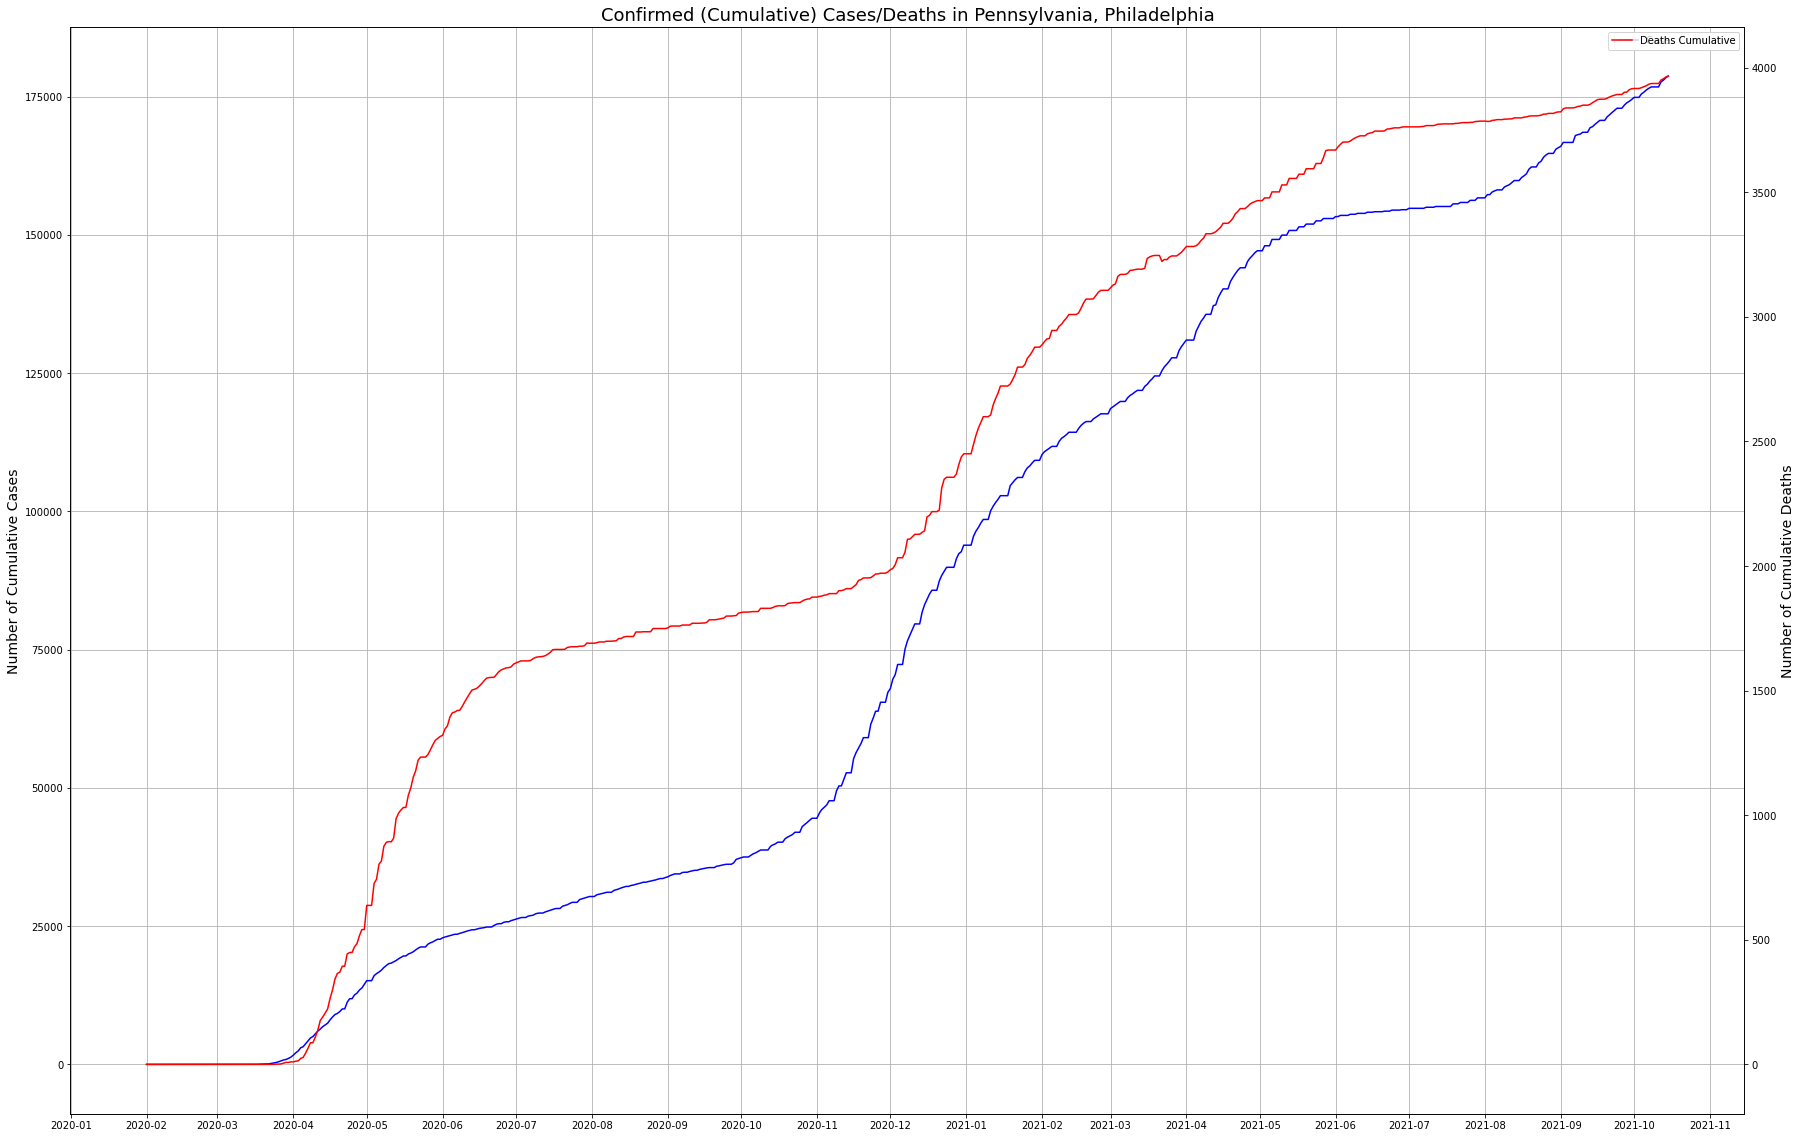

In [16]:
plt.figure(figsize=(30,20))
ax = plt.gca()
ax2 = ax.twinx()

# Create lines and choose characteristics
ax.plot('Date', 'Cases Cumulative', 'b', data=philly_cases_df, label='Cases Cumulative')
ax2.plot('Date', 'Deaths Cumulative', 'r', data=philly_cases_df, label='Deaths Cumulative')

# format the x-ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_minor_locator(months)

# Add title and axis names
plt.title(f'Confirmed (Cumulative) Cases/Deaths in {STATE_NAME}, {COUNTY_NAME}', fontsize=18)
plt.xlabel('Date', fontsize=14)
ax.set_ylabel('Number of Cumulative Cases', fontsize=14)
ax2.set_ylabel('Number of Cumulative Deaths', fontsize=14)

ax.grid()
ax.legend()
ax2.legend()

## Process mask mandates data

In [17]:
mask_mandate_df = pd.read_csv(
    os.path.join(RAW_DATA_PATH, MASK_MANDATE_FILE)
)

In [18]:
mask_mandate_df.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,AL,Autauga County,1,1,4/10/2020,2,NaN,NaN,NaN,NaN
1,AL,Autauga County,1,1,4/11/2020,2,NaN,NaN,NaN,NaN
2,AL,Autauga County,1,1,4/12/2020,2,NaN,NaN,NaN,NaN
3,AL,Autauga County,1,1,4/13/2020,2,NaN,NaN,NaN,NaN
4,AL,Autauga County,1,1,4/14/2020,2,NaN,NaN,NaN,NaN


In [19]:
# Extract the assigned state and county data
philly_mask_mandate_df = (mask_mandate_df.loc[
    (mask_mandate_df['State_Tribe_Territory']==STATE_NAME_ABB) &\
    (mask_mandate_df['County_Name']==COUNTY_NAME_MASK_MANDATE_STR)
]).copy()

# Convert date to relevant data type
philly_mask_mandate_df['date'] = pd.to_datetime(philly_mask_mandate_df['date'])

# Extract the relevant dates we are trying to analyze
mask = (philly_mask_mandate_df['date'] >= '2020-2-1') & (philly_mask_mandate_df['date'] <= '2021-10-15')
philly_mask_mandate_df = philly_mask_mandate_df.loc[mask]

# Convert the Yes/No flags to a boolean for easy visualization
philly_mask_mandate_df[['Face_Masks_Required_in_Public_Embedded']] = philly_mask_mandate_df[['Face_Masks_Required_in_Public']].replace(
    {"Yes": 1, "No": 0}
)

In [20]:
philly_mask_mandate_df.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation,Face_Masks_Required_in_Public_Embedded
610213,PA,Philadelphia County,42,101,2020-04-10,2,NaN,NaN,NaN,NaN,NaN
610214,PA,Philadelphia County,42,101,2020-04-11,2,NaN,NaN,NaN,NaN,NaN
610215,PA,Philadelphia County,42,101,2020-04-12,2,NaN,NaN,NaN,NaN,NaN
610216,PA,Philadelphia County,42,101,2020-04-13,2,NaN,NaN,NaN,NaN,NaN
610217,PA,Philadelphia County,42,101,2020-04-14,2,NaN,NaN,NaN,NaN,NaN


### Visualize - Daily moving average cases and mask mandate

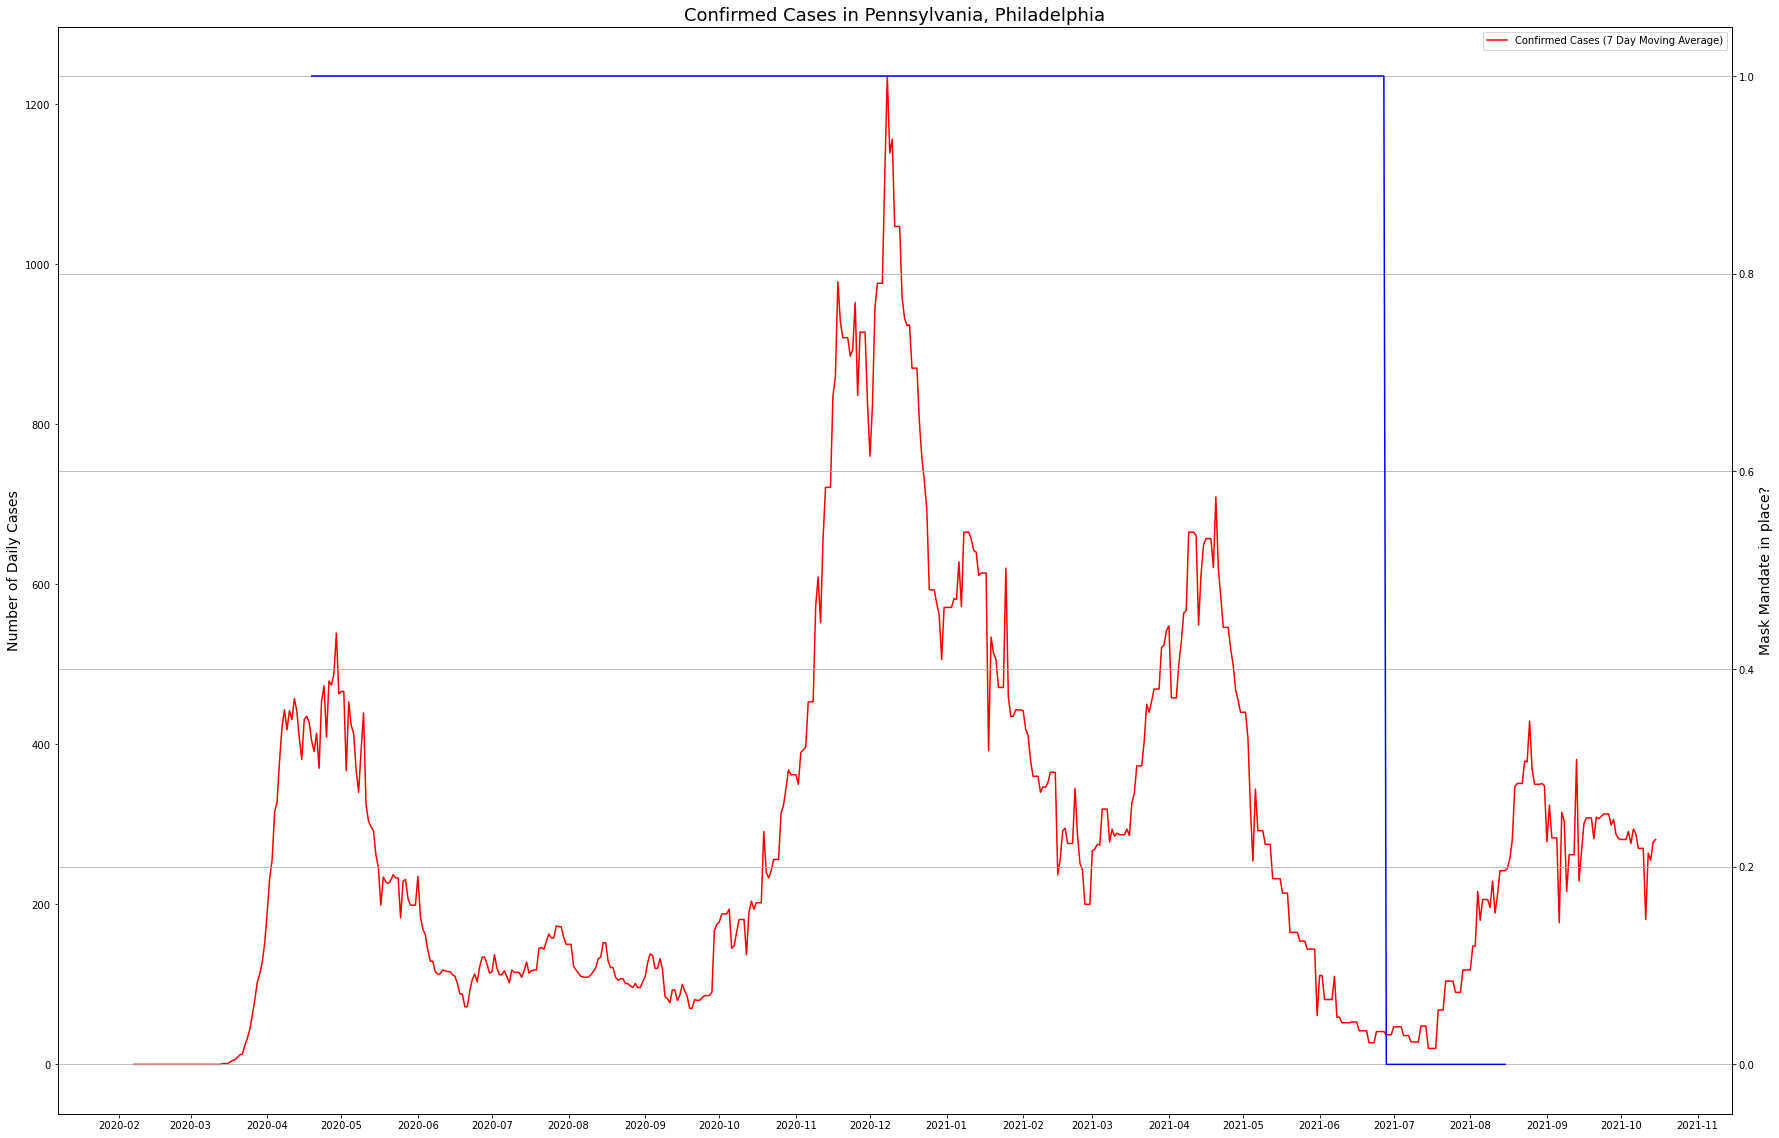

In [21]:
plt.figure(figsize=(30,20))
ax = plt.gca()
ax2 = ax.twinx()

# Create lines and choose characteristics
ax.plot('Date', 'Cases Moving Average', 'r', data=philly_cases_df, label='Confirmed Cases (7 Day Moving Average)')
ax2.plot('date', 'Face_Masks_Required_in_Public_Embedded', 'b', data=philly_mask_mandate_df, label='Is Mask Policy in Effect?')

# format the x-ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_minor_locator(months)

# Add title and axis names
plt.title(f'Confirmed Cases in {STATE_NAME}, {COUNTY_NAME}', fontsize=18)
plt.xlabel('Date', fontsize=14)
ax.set_ylabel('Number of Daily Cases', fontsize=14)
ax2.set_ylabel('Mask Mandate in place?', fontsize=14)

plt.grid()
ax.legend()

In [22]:
philly_combined_df = pd.merge(philly_cases_df, philly_mask_mandate_df, how='left', left_on='Date', right_on='date')

philly_combined_df = philly_combined_df[
    ['Date',
     'Initial Population', 'Susceptible Population',
     'Cases', 'Cases Moving Average', 'Cases Cumulative', 'Rate of Cases', 'Rate of Daily Cases',
     'Deaths', 'Deaths Moving Average', 'Deaths Cumulative',
     'Rate of Infection', 'Rate of Daily Infection'
    ]
]

philly_combined_df.to_csv(os.path.join(PROCESSED_DATA_PATH, COMBINED_DATA_FILE),
                          index=False)

### Visualize - Trends in daily cases, mask mandate and rate of infection

*Note: Here we make the assumption that the mask mandate was enforced in between the datat points that we have.*

In [23]:
# Based on the above visualization we can MANUALLY extract the start and end of the mask mandate
MANDATE_DATE_END = datetime.datetime(2021, 6, 27)
MANDATE_DATE_START = datetime.datetime(2020, 4, 19)

In [24]:
case_rate_mean = philly_combined_df['Rate of Cases'].mean()
case_rate_std = philly_combined_df['Rate of Cases'].std()

print(f'Mean: {case_rate_mean:.6f}, StdDev: {case_rate_std:.6f}')

Mean: 0.000028, StdDev: 0.002235


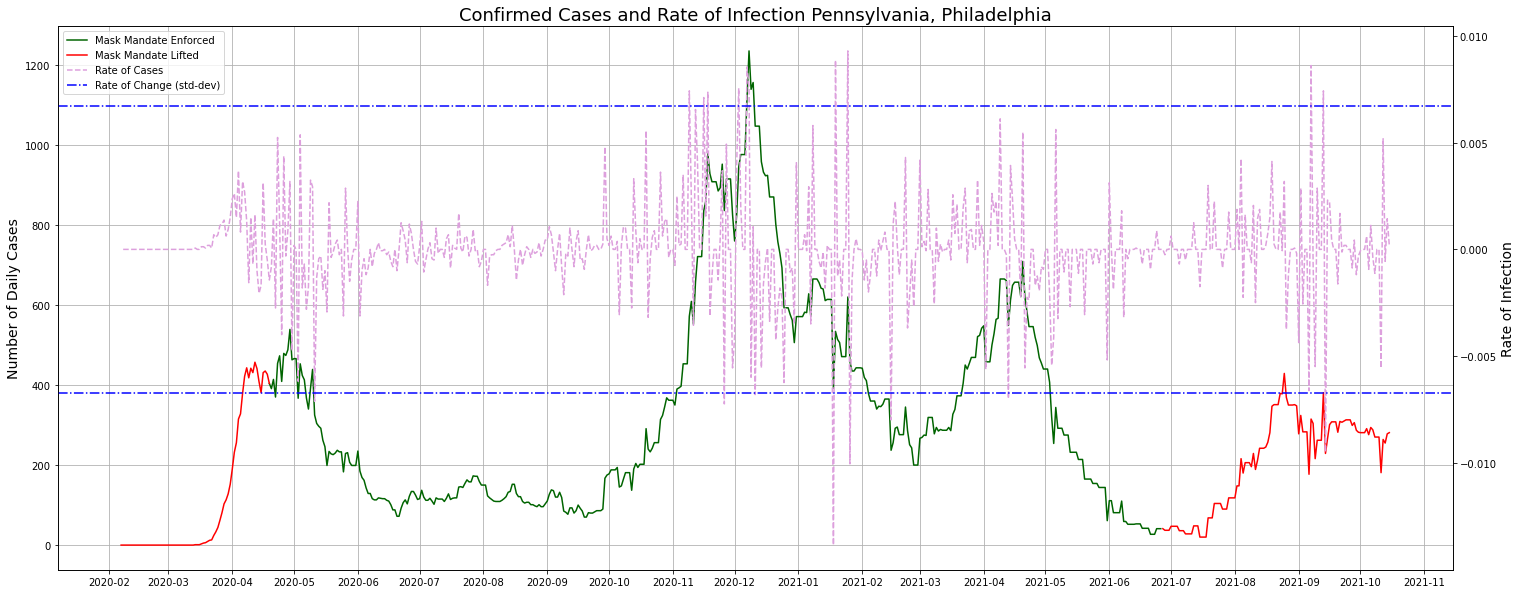

In [25]:
# Cut the df so that we can get different colored lines for pre/during/post mask mandates
mask_enforced_philly_combined_df = philly_combined_df.loc[(philly_combined_df['Date'] >= MANDATE_DATE_START) & (philly_combined_df['Date'] < MANDATE_DATE_END)]
pre_mask_enforced_philly_combined_df = philly_combined_df.loc[(philly_combined_df['Date'] <= MANDATE_DATE_START)]
post_mask_enforced_philly_combined_df = philly_combined_df.loc[(philly_combined_df['Date'] >= MANDATE_DATE_END)]

plt.figure(figsize=(25,10))
ax = plt.gca()
ax2 = ax.twinx()

# Create lines and choose characteristics
ax.plot('Date', 'Cases Moving Average', 'darkgreen', data=mask_enforced_philly_combined_df, label='Mask Mandate Enforced')
ax.plot('Date', 'Cases Moving Average', 'r', data=pre_mask_enforced_philly_combined_df, label='Mask Mandate Lifted')
ax.plot('Date', 'Cases Moving Average', 'r', data=post_mask_enforced_philly_combined_df, label='')
# ax2.plot('Date', 'Rate of Daily Infection', color='plum', ls='--', data=philly_combined_df, label='Rate of Infection')
ax2.plot('Date', 'Rate of Cases', color='plum', ls='--', data=philly_combined_df, label='Rate of Cases')

ax2.axhline(y=3*case_rate_std, color='b', linestyle='dashdot', label='Rate of Change (std-dev)')
ax2.axhline(y=-3*case_rate_std, color='b', linestyle='dashdot')

# format the x-ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)

# Add title and axis names
plt.title(f'Confirmed Cases and Rate of Infection {STATE_NAME}, {COUNTY_NAME}', fontsize=18)
plt.xlabel('Date', fontsize=14)
ax.set_ylabel('Number of Daily Cases', fontsize=14)
ax2.set_ylabel('Rate of Infection', fontsize=14)

ax.grid()

# Add legend for both the axes
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

ax.legend(lines, labels, loc=2)

### Visualize - Trends in daily cases, mask mandate and rate of change in daily cases

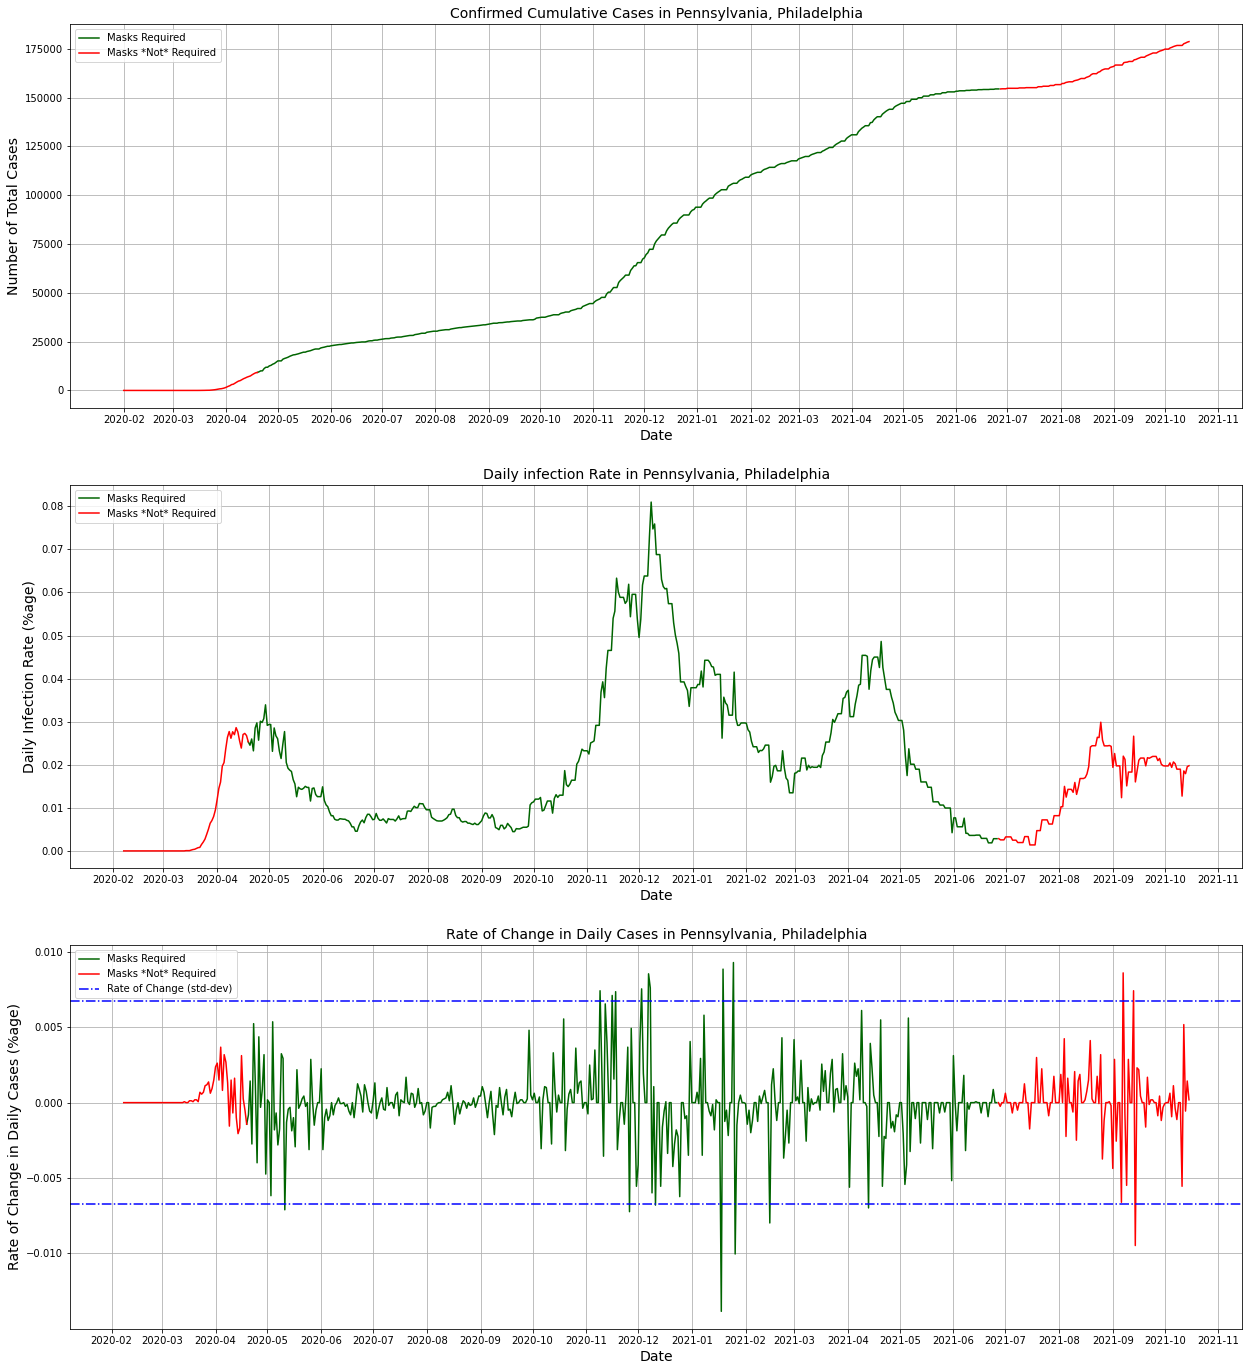

In [26]:
fig, (ax, ax2, ax3) = plt.subplots(3)

# ax.plot('Date', 'Cases Moving Average', 'darkgreen', data=mask_enforced_philly_combined_df, label='Masks Required')
# ax.plot('Date', 'Cases Moving Average', 'r', data=pre_mask_enforced_philly_combined_df, label='Masks *Not* Required')
# ax.plot('Date', 'Cases Moving Average', 'r', data=post_mask_enforced_philly_combined_df, label='')

ax.plot('Date', 'Cases Cumulative', 'darkgreen', data=mask_enforced_philly_combined_df, label='Masks Required')
ax.plot('Date', 'Cases Cumulative', 'r', data=pre_mask_enforced_philly_combined_df, label='Masks *Not* Required')
ax.plot('Date', 'Cases Cumulative', 'r', data=post_mask_enforced_philly_combined_df, label='')

ax2.plot('Date', 'Rate of Infection', 'darkgreen', data=mask_enforced_philly_combined_df, label='Masks Required')
ax2.plot('Date', 'Rate of Infection', 'r', data=pre_mask_enforced_philly_combined_df, label='Masks *Not* Required')
ax2.plot('Date', 'Rate of Infection', 'r', data=post_mask_enforced_philly_combined_df, label='')

ax3.plot('Date', 'Rate of Cases', 'darkgreen', data=mask_enforced_philly_combined_df, label='Masks Required')
ax3.plot('Date', 'Rate of Cases', 'r', data=pre_mask_enforced_philly_combined_df, label='Masks *Not* Required')
ax3.plot('Date', 'Rate of Cases', 'r', data=post_mask_enforced_philly_combined_df, label='')

ax3.axhline(y=3*case_rate_std, color='b', linestyle='dashdot', label='Rate of Change (std-dev)')
ax3.axhline(y=-3*case_rate_std, color='b', linestyle='dashdot')

ax.legend(loc=2)
ax2.legend(loc=2)
ax3.legend(loc=2)

# format the x-ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y-%m')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(yearsFmt)
ax.grid()

ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.grid()

ax3.xaxis.set_major_locator(months)
ax3.xaxis.set_major_formatter(yearsFmt)
ax3.grid()

ax.set_title(f'Confirmed Cumulative Cases in {STATE_NAME}, {COUNTY_NAME}', fontsize=14)
ax2.set_title(f'Daily infection Rate in {STATE_NAME}, {COUNTY_NAME}', fontsize=14)
ax3.set_title(f'Rate of Change in Daily Cases in {STATE_NAME}, {COUNTY_NAME}', fontsize=14)

ax.set_xlabel('Date', fontsize=14)
ax2.set_xlabel('Date', fontsize=14)
ax3.set_xlabel('Date', fontsize=14)

ax.set_ylabel('Number of Total Cases', fontsize=14)
ax2.set_ylabel('Daily Infection Rate (%age)', fontsize=14)
ax3.set_ylabel('Rate of Change in Daily Cases (%age)', fontsize=14)

fig.set_size_inches(21, 24)

## Analyze data from mask usage survey

In [27]:
mask_usage_df = pd.read_csv(
    os.path.join(RAW_DATA_PATH, MASK_USE_FILE)
)

In [28]:
mask_usage_df.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


In [29]:
mask_usage_df[mask_usage_df['COUNTYFP'] == COUNTY_FIPS_CODE]

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
2294,42101,0.023,0.012,0.051,0.12,0.794
